In [1]:
# required imports
import numpy as np
import pandas as pd
import altair as alt
from altair import datum, expr
import matplotlib.pyplot as plt
import sklearn
import math
from math import e
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 


In [2]:
#Load Data
states_data = pd.read_csv('states.csv') # This data contains full state and territory names as well as lat/long
df=pd.read_csv('firesData.csv')
df

c:\users\charlotte\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,36,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,...,A,40.036944,-121.005833,5.0,USFS,CA,63,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,...,A,38.933056,-120.404444,5.0,USFS,CA,61,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,...,A,38.559167,-119.913333,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,...,A,38.559167,-119.933056,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,1880460,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,...,A,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...
1880461,1880461,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880462,1880462,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880463,1880463,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,...,B,37.672235,-120.898356,12.0,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb...


In [3]:
df.columns

Index(['Unnamed: 0', 'OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE',
       'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

# Data Manipulation
1. Time Binning
2. Data Grouping
3. Fire Risk Calculation

In [4]:
"""
Note to the dev. The variable "Decade" was chosen haphazardly and represents
a now-defunct design choice. A total refactor to instead use TIME_BIN or
TIME_PERIOD would aid readability.
"""

def to_decade(year):
  if year <= 1999:
    return "1993-1999"
  elif year <= 2004:
    return "2000-2004"
  elif year <= 2009:
    return "2005-2009"
  elif year <= 2015:
    return "2010-2015"
  return None

# Create the Decade column for time series binning
df["DECADE"] = df["FIRE_YEAR"].apply(to_decade)
df["DECADE_NUMBER"] = df["DECADE"].apply(lambda d: ["1993-1999", "2000-2004", "2005-2009", "2010-2015"].index(d))

df.sample(n=10)

,Unnamed: 0,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,...,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,DECADE,DECADE_NUMBER
60604,60604,60605,61214,FS-285765,FED,FS-FIRESTAT,FS,USWAOWF,Okanogan/Wenatchee National Forest,617,...,-121.266667,5.0,USFS,WA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00P\xa5\x14\x11\x11Q^\...,1993-1999,0
793767,793767,793768,899945,SCHMIDT_55006164,NONFED,ST-WIWIS,ST/C&L,USWIWIS,Wisconsin Department of Natural Resources,WIWIS,...,-88.052588,14.0,MISSING/NOT SPECIFIED,WI,Oconto,83.0,Oconto,b'\x00\x01\xad\x10\x00\x00\x10\xbd\x10\x9b]\x0...,1993-1999,0
476744,476744,476745,513342,SFO-LA01420606-0663,NONFED,ST-NASF,ST/C&L,USLALAS,Louisiana Office of Forestry,LALA5,...,-92.257190,14.0,MISSING/NOT SPECIFIED,LA,Union,111.0,Union,b'\x00\x01\xad\x10\x00\x00\x8c\x97\xc9\xcbu\x1...,2005-2009,2
699659,699659,699660,777465,MSARCH_21634,NONFED,ST-MSMSS,ST/C&L,USMSMSS,Mississippi Forestry Commission,MSMSS,...,-90.083647,14.0,MISSING/NOT SPECIFIED,MS,Lawrence,77.0,Lawrence,b'\x00\x01\xad\x10\x00\x00\x8c\x9a\x1bxZ\x85V\...,1993-1999,0
455171,455171,455172,489478,SFO-GA0403-37-303-0011-08,NONFED,ST-NASF,ST/C&L,USGAGAS,Georgia Forestry Commission,GA Milledgeville,...,-82.657570,14.0,MISSING/NOT SPECIFIED,GA,Washington,303.0,Washington,b'\x00\x01\xad\x10\x00\x00\x18q3\xa2\x15\xaaT\...,2005-2009,2
184755,184755,184756,187025,W-378078,FED,DOI-WFMI,BIA,USMNRLA,Red Lake Agency,MNRLA,...,-95.016900,2.0,BIA,MN,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00X\xd3\xbc\xe3\x14\xc...,1993-1999,0
708076,708076,708077,785995,MSARCH_31825,NONFED,ST-MSMSS,ST/C&L,USMSMSS,Mississippi Forestry Commission,MSMSS,...,-89.905281,14.0,MISSING/NOT SPECIFIED,MS,Panola,107.0,Panola,b'\x00\x01\xad\x10\x00\x00\xf8\xd1\xe4 \xf0yV\...,1993-1999,0
825006,825006,825007,946136,STATE_MS_86491,NONFED,ST-MSMSS,ST/C&L,USMSMSS,Mississippi Forestry Commission,MS Northeast,...,-88.695300,14.0,MISSING/NOT SPECIFIED,MS,NaN,NaN,NaN,"b'\x00\x01\xad\x10\x00\x00(:\x92\xcb\x7f,V\xc0...",2000-2004,1
1359972,1359972,1359973,15000180,ICS209_2010_KY-KYS-10-2007,INTERAGCY,IA-ICS209,ST/C&L,USKYKYS,Kentucky Division of Forestry,KYKYS,...,-82.753889,14.0,MISSING/NOT SPECIFIED,KY,Knott,119.0,Knott,b'\x00\x01\xad\x10\x00\x00\x18\xf4\xa5\xb7?\xb...,2010-2015,3
141678,141678,141679,143062,FS-369444,FED,FS-FIRESTAT,FS,USNCNCF,National Forests in North Carolina,811,...,-83.768333,5.0,USFS,NC,43,43.0,Clay,"b'\x00\x01\xad\x10\x00\x00\xb41\x8f_,\xf1T\xc0...",2000-2004,1


In [5]:
# Frequency of fire, by state and decade
df["STATE_DECADE_FREQUENCY"] = df.groupby(["DECADE", "STATE"])["STATE"].transform(pd.Series.count)
# Precalculate the sum of fire size by state and decade
df["STATE_DECADE_FIRE_SIZE_SUM"] = df.groupby(["DECADE", "STATE"])["FIRE_SIZE"].transform(pd.Series.sum)

df


,Unnamed: 0,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,...,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,DECADE,DECADE_NUMBER,STATE_DECADE_FREQUENCY,STATE_DECADE_FIRE_SIZE_SUM
0,0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,...,USFS,CA,63,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-2009,2,39784,4002222.070
1,1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,...,USFS,CA,61,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2000-2004,1,37623,2450856.420
2,2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,...,STATE OR PRIVATE,CA,17,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2000-2004,1,37623,2450856.420
3,3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,...,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2000-2004,1,37623,2450856.420
4,4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,...,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2000-2004,1,37623,2450856.420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,1880460,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,...,STATE OR PRIVATE,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...,2010-2015,3,44128,3055018.282
1880461,1880461,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,...,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...,2010-2015,3,44128,3055018.282
1880462,1880462,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,...,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...,2010-2015,3,44128,3055018.282
1880463,1880463,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,...,MUNICIPAL/LOCAL,CA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb...,2010-2015,3,44128,3055018.282


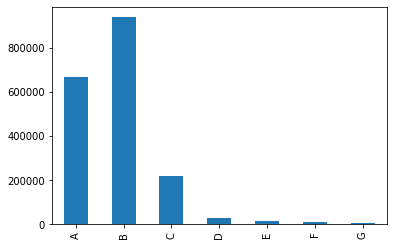

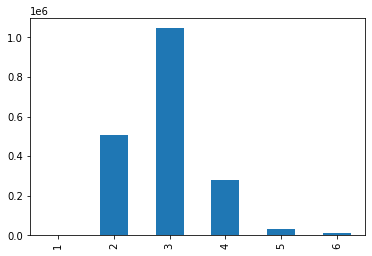

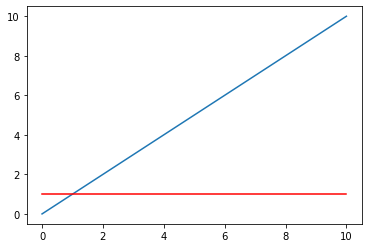

,Unnamed: 0,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,...,DECADE_NUMBER,STATE_DECADE_FREQUENCY,STATE_DECADE_FIRE_SIZE_SUM,WEIGHTS,MIN_FIRE_SIZE_STATE_DECADE,MAX_FIRE_SIZE_STATE_DECADE,MEAN_FIRE_SIZE_STATE_DECADE,WAV_FIRE_SIZE_STATE_DECADE,CATAGORY,CATAGORY_LETTER
1644000,1771736,1771737,300117266,SFO-2014GAGAS-FY2015-Bartow-011,NONFED,ST-NASF,ST/C&L,USGAGAS,Georgia Forestry Commission,GAGAS,...,3,28907,5.350057e+05,9.6,0.010,309200.0,18.507825,18.507825,3,C
588707,724159,724160,822250,NM97-52990713X,NONFED,ST-NMNMS,ST/C&L,USNMNMS,New Mexico - State Forestry,NMNMS,...,0,13125,1.480187e+06,25.0,0.010,41800.0,112.776123,112.776123,4,D
1399132,542385,542386,583417,SFO-NJ0285-01_A110704,NONFED,ST-NASF,ST/C&L,USNJNJS,New Jersey Forest Fire Service,NJNJA,...,1,5455,1.362625e+04,3.0,0.100,2600.0,2.497938,2.497938,2,B
741518,1376379,1376380,19071991,SFO-GA-TOO-92-4/14/1996-1545,NONFED,ST-GAGAS,ST/C&L,USGAGAS,Georgia Forestry Commission,GAGAS,...,0,65667,2.959122e+05,16.5,0.010,16100.0,4.506254,4.506254,2,B
1303679,917911,917912,1045160,SWRA_SC_58791,NONFED,ST-SCSCS,ST/C&L,USSCSCS,South Carolina Forestry Commission,SCSCS4,...,1,20276,1.373235e+05,0.1,0.010,3684.0,6.772709,6.772709,2,B
269350,1527817,1527818,201382422,TFS-TXFD2009-179841,NONFED,ST-TXTXS,ST/C&L,USTXTXS,Texas A & M Forest Service,TXVFD,...,2,59609,4.317848e+06,2.0,0.010,479549.0,72.436184,72.436184,3,C
842094,695061,695062,772805,MSARCH_9287,NONFED,ST-MSMSS,ST/C&L,USMSMSS,Mississippi Forestry Commission,MSMSS,...,0,33407,4.772797e+05,15.0,0.100,5208.0,14.286817,14.286817,3,C
30778,1117849,1117850,1362026,CDF_2009_54_2217_014010,NONFED,ST-CACDF,ST/C&L,USCANEU,Nevada-Yuba-Placer Unit,CANEU,...,2,39784,4.002222e+06,8.0,0.010,240207.0,100.598785,100.598785,4,D
1275011,253135,253136,258096,W-307463,FED,DOI-WFMI,BIA,USNDFTA,Fort Totten Agency,NDFTA,...,1,3741,1.183094e+05,0.5,0.100,15732.2,31.625071,31.625071,3,C
1730122,1818603,1818604,300236779,SFO-2015KS0000768,NONFED,ST-NASF,ST/C&L,USKSKSS,Kansas State Forestry,KSKSS,...,3,6129,3.416524e+05,3.0,0.001,40000.0,55.743578,55.743578,3,C


In [6]:
"""
Note: The copious use of df.apply(...) makes this section run particularly slowly
especially on the full datatset.
Less heavy data transformation could be used to reduce this overhead.
"""

def grade_fire_size(fire_size):
  """
  Takes fire size (in acres) and returns the fire size designation as an index.
  These values are taken from https://www.nwcg.gov/data-standards/approved/fire-size-class
  As the dataset tracks all fires >= 5000 as a G we cutoff at this place too
  These can be converted to letters alphabetically
  """
  size_cutoffs = [0.26, 10, 100, 300, 1000, 5000]
  indicies = [1, 2, 3, 4, 5, 6]
  for index, limit in zip(indicies, size_cutoffs):
    if fire_size < limit:
      return index
  # Code G is for all fires larger than 5000 acres
  return 7

def weight_function(x):
  """
  How the weight of a value should be decided
  params:
    x: ndarray or df projection
  """
  return x

# Precalc weights
df["WEIGHTS"] = weight_function(df["FIRE_SIZE"])

aggs = df.groupby(["STATE", "DECADE"])["FIRE_SIZE"].agg(
    MIN_FIRE_SIZE_STATE_DECADE=np.min,
    MAX_FIRE_SIZE_STATE_DECADE=np.max,
    MEAN_FIRE_SIZE_STATE_DECADE=np.mean).reset_index()
aggs = pd.merge(aggs, df.groupby(["STATE", "DECADE"]).apply(lambda x: np.average(x['FIRE_SIZE'])).reset_index(name="WAV_FIRE_SIZE_STATE_DECADE"), on=['STATE', 'DECADE'])

df = pd.merge(df, aggs, on=['STATE', 'DECADE'])

df["CATAGORY"] = df.apply(lambda row: grade_fire_size(row.WAV_FIRE_SIZE_STATE_DECADE), axis = 1)
df["CATAGORY_LETTER"] = df.apply(lambda row: chr(ord('A') + (row.CATAGORY - 1)), axis = 1)
df["FIRE_SIZE_CLASS"].value_counts().sort_index().plot.bar()

# For distribution mapping purposes
plt.show()
df["CATAGORY"].value_counts().sort_index().plot.bar()
plt.show()

x_max = 10
plt.plot(np.linspace(0, x_max, 10000), weight_function(np.linspace(0, x_max, 10000)))
plt.plot([0, x_max], [1, 1], color="red")
plt.show()

df.sample(n=10)

# Linear Regression

In [7]:
# Linear Regression model shorthand

def train_model(Xs, ys):
  X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.3, random_state=0)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  return model, r2_score(y_test, y_pred)

def plot_model(Xs, ys, model):
  plt.scatter(Xs, ys)
  plt.plot((min(Xs), max(Xs)), (model.predict([[min(Xs)]])[0][0], model.predict([[max(Xs)]])[0][0]), 'red')
  plt.show()

In [8]:
state_models = {}
for state in df["STATE"].unique():
  state_proj = df[df["STATE"] == state]
  if(len(state_proj) <= 2):
    continue
  state_models[state] = {}
  freqs = state_proj.groupby(["FIRE_YEAR"])["FIRE_YEAR"].count().reset_index(name="FREQUENCY")
  # Add the training data to each model
  state_models[state]["Fire Size"] = train_model(state_proj["FIRE_YEAR"].values.reshape(-1,1), state_proj["FIRE_SIZE"].values.reshape(-1,1))
  state_models[state]["Fire Freq"] = train_model(freqs["FIRE_YEAR"].values.reshape(-1,1), freqs["FREQUENCY"].values.reshape(-1,1))
  state_models[state]["Fire Catagory"] = train_model(state_proj["DECADE_NUMBER"].values.reshape(-1,1), state_proj["CATAGORY"].values.reshape(-1,1))
print(state_models)

{'CA': {'Fire Size': (LinearRegression(), -1.1746494812836517e-05), 'Fire Freq': (LinearRegression(), -0.29834489533923936), 'Fire Catagory': (LinearRegression(), 0.08824590377236385)}, 'NM': {'Fire Size': (LinearRegression(), -0.0017109481082242528), 'Fire Freq': (LinearRegression(), 0.4010757648825737), 'Fire Catagory': (LinearRegression(), 1.0)}, 'OR': {'Fire Size': (LinearRegression(), 0.0008659323242961037), 'Fire Freq': (LinearRegression(), -0.6076798648656621), 'Fire Catagory': (LinearRegression(), 0.6815254968685907)}, 'NC': {'Fire Size': (LinearRegression(), 5.678539197040422e-05), 'Fire Freq': (LinearRegression(), -0.2686760373841559), 'Fire Catagory': (LinearRegression(), 1.0)}, 'WY': {'Fire Size': (LinearRegression(), -0.00024591969105647316), 'Fire Freq': (LinearRegression(), -0.5142864651852297), 'Fire Catagory': (LinearRegression(), 1.0)}, 'CO': {'Fire Size': (LinearRegression(), -0.0013469508758319204), 'Fire Freq': (LinearRegression(), -0.9853686397705701), 'Fire Catag

In [9]:
# Show the states in state data on a chart, for debugging purposes
alt.Chart(states_data).mark_circle(size=60).encode(
    x='LON',
    y='LAT',
    tooltip=["STATE"]
).interactive()

alt.Chart(...)

# Circle Repulsion and Attraction packing

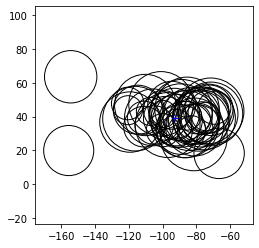

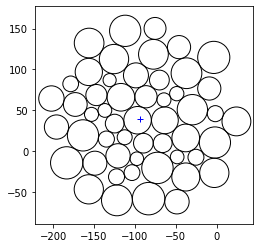

In [10]:
"""
Code for circle repulsion
"""
class Circle:
	def __init__(self, x, y, r, c = '#000000'):
		self.xy = np.array([x,y])
		self.r = r
		self.c = c

	@property
	def x(self):
		return self.xy[0]

	@property
	def y(self):
		return self.xy[1]

	def sqd_distance(self, other):
		delta_x = other.x - self.x
		delta_y = other.y - self.y
		return delta_x * delta_x + delta_y * delta_y

	def distance(self, other):
		return math.sqrt(self.sqd_distance(other))

	def direction(self, other):
		return other.xy - self.xy

	def intersects(self, other):
		r_comb = self.r + other.r
		# Bounding box test
		if self.x - r_comb < other.x < self.x + r_comb and self.y - r_comb < other.y < self.y + r_comb:
			return self.sqd_distance(other) < r_comb ** 2
		return False

	@staticmethod
	def random_circle(max_x, max_y, max_r):
		x = np.random.uniform(0, max_x)
		y = np.random.uniform(0, max_y)
		c = '#%02x%02x%02x' % (int(255*x/max_x), 0, int(255*y/max_y))
		return Circle(np.random.uniform(0, max_x), np.random.uniform(0, max_y), np.random.uniform(0, max_r), c=c)

	def __str__(self):
		return "CIRCLE ({0}, {1}) r={2}".format(self.x, self.y, self.r)

def find_center(circles):
	xs = [c.x for c in circles]
	ys = [c.y for c in circles]
	return np.mean(xs), np.mean(ys)

def circle_repel(circles):
	# Sort circles by distance from the center (assume that we wish to handle the furthest from center first
	midpoint = np.array(find_center(circles))
	midpoint_circle = Circle(midpoint[0], midpoint[1], 0)
	done = False
	tolerence = 0.25
	# Separate circles out
	while not done:
		done = True
		sorted_circles = sorted(circles, reverse=True, key=lambda c: midpoint_circle.sqd_distance(c))

		for i in range(len(sorted_circles) - 1):
			circle = sorted_circles[i]
			for j in range(i+1, len(sorted_circles)):
				other_circle = sorted_circles[j]
				if circle != other_circle and circle.intersects(other_circle):
					# In the case that the two circles lie on the same point exactly
					if all(circle.xy == other_circle.xy):
						# In the case that this is also the exact midpoint
						if all(circle.xy == midpoint):
							travel_vector = np.random.random(2)
						else:
							travel_vector = circle.xy - midpoint
					else:
						travel_vector = other_circle.direction(circle)

					travel_vector = travel_vector / np.linalg.norm(travel_vector)
					# By how much do the circles need to move
					overlap = ((circle.r + other_circle.r) - circle.distance(other_circle)) + tolerence

					ratio = other_circle.r / (circle.r + other_circle.r)
					this_move = ratio * overlap
					other_move = (1 - ratio) * overlap
					circle.xy = circle.xy + (travel_vector * this_move)
					other_circle.xy = other_circle.xy - (travel_vector * other_move)
					done = False

	# Collect them together
	sorted_circles = sorted(circles, reverse=False, key=lambda c: midpoint_circle.distance(c) - c.r)
	for circle in sorted_circles:
		midpoint_distance = midpoint_circle.distance(circle) - circle.r
		closest_neighbour_distance = None
		closest_neighbour = None
		for other_circle in sorted_circles:
			if circle != other_circle and midpoint_circle.distance(other_circle) - circle.r <= midpoint_distance:
				d = circle.distance(other_circle) - (circle.r + other_circle.r)
				if closest_neighbour is None or d < closest_neighbour_distance:
					closest_neighbour = other_circle
					closest_neighbour_distance = d
		if closest_neighbour is None:
			#handle first circle case
			continue
		if closest_neighbour_distance < (tolerence * 2):
			# Already borders another circle
			continue
		travel_vector = circle.direction(closest_neighbour)
		travel_vector = (closest_neighbour_distance * travel_vector) / np.linalg.norm(travel_vector)
		circle.xy = circle.xy + travel_vector



def plot_circles(circles, midpoint=None):
	xs = [c.x for c in circles]
	ys = [c.y for c in circles]
	rs = [c.r for c in circles]
	xs_range = max(xs) - min(xs)
	ys_range = max(ys) - min(ys)
	max_range = max(xs_range, ys_range) + (2 * max(rs))
	xs_midpoint = min(xs) + (xs_range / 2)
	ys_midpoint = min(ys) + (ys_range / 2)

	figure, ax = plt.subplots()
	plt.xlim(xs_midpoint - max_range / 2, xs_midpoint + max_range / 2)
	plt.ylim(ys_midpoint - max_range / 2, ys_midpoint + max_range / 2)

	for circle in circles:
		draw_circle = plt.Circle((circle.x, circle.y), circle.r, fill=False, color=circle.c)
		ax.add_artist(draw_circle)

	if midpoint is not None:
		plt.plot(midpoint[0], midpoint[1], 'b+')

	ax.set_aspect(1)
	plt.show()
 
def pack_circles(data, x_key, y_key, size_key, foreign_key=None, fit_unit_circle=True, size_normalizing_factor = (.05, .25)):
  if foreign_key is not None:
    circle_df = data[[x_key, y_key, size_key, foreign_key]].copy()
  else:
    circle_df = data[[x_key, y_key, size_key]].copy()

  x_range = circle_df[x_key].max() - circle_df[x_key].min()
  y_range = circle_df[y_key].max() - circle_df[y_key].min()
  size_range = circle_df[size_key].max() - circle_df[size_key].min()
  max_range = max(x_range, y_range)
  # Set all sizes between one tenth and one quarter of the screen. This is set experimentally
  scale = max_range * size_normalizing_factor[0], max_range * size_normalizing_factor[1]
  if size_range == 0:
    circle_df[size_key] = 1
  else:
    circle_df[size_key] = (circle_df[size_key] - circle_df[size_key].min()) / size_range
    circle_df[size_key] *= scale[1] - scale[0]
    circle_df[size_key] += scale[0]
  
  circle_data = {
    i if foreign_key is None else row[foreign_key]: Circle(row[x_key], row[y_key], row[size_key]) for i, row in circle_df.iterrows()
  }
  circles = list(circle_data.values())
  circle_repel(circles)
  if foreign_key is None:
    packed_data = pd.DataFrame({
      'CIRCLE_X': [c.x for c in circles],
      'CIRCLE_Y': [c.y for c in circles],
      'CIRCLE_R': [c.r for c in circles]
      })
  else:
    packed_data = pd.DataFrame({
    'CIRCLE_X': [c.x for c in circles],
    'CIRCLE_Y': [c.y for c in circles],
    'CIRCLE_R': [c.r for c in circles],
    foreign_key: [row[foreign_key] for _, row in circle_df.iterrows()]
    })
  if not fit_unit_circle:
    return packed_data
  # Transform the data into altair chart space. Altair, it seems,
  # DOES NOT WANT ANYBODY plotting a circle on their charts the easy way
  # so this is the workaround.
  extents_x_min = (packed_data["CIRCLE_X"] - packed_data["CIRCLE_R"]).min()
  extents_x_max = (packed_data["CIRCLE_X"] + packed_data["CIRCLE_R"]).max()
  extents_y_min = (packed_data["CIRCLE_Y"] - packed_data["CIRCLE_R"]).min()
  extents_y_max = (packed_data["CIRCLE_Y"] + packed_data["CIRCLE_R"]).max()
  midpoint_x = extents_x_min + ((extents_x_max - extents_x_min) / 2)
  midpoint_y = extents_y_min + ((extents_y_max - extents_y_min) / 2)
  extents_max = max(extents_x_max - extents_x_min, extents_y_max - extents_y_min)
  # Transform the data into altair space (normalized between -1 and 1)
  packed_data["CIRCLE_X"] = packed_data["CIRCLE_X"] - midpoint_x
  packed_data["CIRCLE_Y"] = packed_data["CIRCLE_Y"] - midpoint_y
  packed_data["CIRCLE_X"] = packed_data["CIRCLE_X"] / (extents_max * 0.5)
  packed_data["CIRCLE_Y"] = packed_data["CIRCLE_Y"] / (extents_max * 0.5)
  packed_data["CIRCLE_R"] = packed_data["CIRCLE_R"] / (extents_max * 0.5)
  packed_data["CIRCLE_A"] = (packed_data["CIRCLE_R"] * 2) ** 2
  return packed_data

# Used to test repulsion visually
circle_data = {i: Circle(row["LON"], row["LAT"], np.random.uniform(8, 20)) for i, row in states_data.iterrows()}
circles = list(circle_data.values())
plot_circles(circles, find_center(circles))
circle_repel(circles)
plot_circles(circles, find_center(circles))


In [11]:
# Combine state and wildfire data so state names are kept.
df = pd.merge(df,
         states_data,
         left_on="STATE",
         right_on="ABBV",
         suffixes=("_ABBV", None),
         how='left')


# Fit Models to Data

In [12]:
## Aggregate Dataframe
working_data = df.groupby(["DECADE", "STATE"]).first().reset_index()
working_data = working_data.drop(["OBJECTID", 'Unnamed: 0', 'OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'Shape', 'WEIGHTS', "STAT_CAUSE_DESCR", "FIRE_SIZE", "FIRE_SIZE_CLASS", "FIRE_YEAR"], axis=1)
for state in working_data["ABBV"].unique():
  if state not in state_models.keys():
    continue
  size_model, _ = state_models[state]["Fire Size"]
  freq_model, _ = state_models[state]["Fire Freq"]
  cat_model, _ = state_models[state]["Fire Catagory"]
  old_row = working_data.loc[working_data['ABBV'] == state]
  catagory = int(round(min(max(cat_model.predict([[2021]])[0][0], 1), 7)))
  freq =  max(0, freq_model.predict([[2021]])[0][0])
  if freq == 0:
    continue
  # Add synthetic data
  new_row = pd.DataFrame({
      "DECADE": ["2021 Predictions"],
      "STATE": [old_row["STATE"].iloc[0]],
      "STATE_ABBV": [old_row["STATE_ABBV"].iloc[0]],
      "DECADE_NUMBER": [-1],
      "STATE_DECADE_FREQUENCY":[ freq],
      "STATE_DECADE_FIRE_SIZE_SUM": [None],
      "MIN_FIRE_SIZE_STATE_DECADE": [None],
      "MAX_FIRE_SIZE_STATE_DECADE": [None],
      "MEAN_FIRE_SIZE_STATE_DECADE": [None],
      "WAV_FIRE_SIZE_STATE_DECADE": [None],
      "CATAGORY": [catagory],
      "CATAGORY_LETTER": [chr(ord('A') + (catagory - 1))],
      "ABBV": [old_row["ABBV"].iloc[0]],
      "LAT": [old_row["LAT"].iloc[0]],
      "LON": [old_row["LON"].iloc[0]],
      "POP": [None]
  })
  working_data = working_data.append(new_row, ignore_index=True)
working_data

,DECADE,STATE,STATE_ABBV,DECADE_NUMBER,STATE_DECADE_FREQUENCY,STATE_DECADE_FIRE_SIZE_SUM,MIN_FIRE_SIZE_STATE_DECADE,MAX_FIRE_SIZE_STATE_DECADE,MEAN_FIRE_SIZE_STATE_DECADE,WAV_FIRE_SIZE_STATE_DECADE,CATAGORY,CATAGORY_LETTER,ABBV,LAT,LON,POP
0,1993-1999,Alabama,AL,0,22618.000000,234998,0.1,3321,10.3899,10.3899,3,C,AL,32.318231,-86.902298,NaN
1,1993-1999,Alaska,AK,0,4729.000000,4.88746e+06,0.1,606945,1033.51,1033.51,6,F,AK,63.588753,-154.493062,NaN
2,1993-1999,Arizona,AZ,0,28580.000000,1.03645e+06,0.01,58960,36.2648,36.2648,3,C,AZ,34.048928,-111.093731,NaN
3,1993-1999,Arkansas,AR,0,5330.000000,64517.6,0.1,1063,12.1046,12.1046,3,C,AR,35.201050,-91.831833,NaN
4,1993-1999,California,CA,0,68015.000000,3.23776e+06,0.1,124898,47.6036,47.6036,3,C,CA,36.778261,-119.417932,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2021 Predictions,Virginia,VA,-1,1119.202011,None,None,None,None,None,7,G,VA,37.431573,-78.656894,None
253,2021 Predictions,Washington,WA,-1,1247.494881,None,None,None,None,None,7,G,WA,47.751074,-120.740139,None
254,2021 Predictions,West Virginia,WV,-1,620.488483,None,None,None,None,None,3,C,WV,38.597626,-80.454903,None
255,2021 Predictions,Wisconsin,WI,-1,660.321389,None,None,None,None,None,2,B,WI,43.784440,-88.787868,None


[-1.0523143863457465, -0.9853686397705701, -0.942818289465774, -0.8907536144919785, -0.8163731393935563, -0.7290196833707216, -0.6154401420349562, -0.6076798648656621, -0.5639389505433361, -0.5142864651852297, -0.43163204228223684, -0.40791858654553503, -0.3951020688613254, -0.37120385248715304, -0.3343817519154064, -0.3302182313693871, -0.3204448302923675, -0.3038625570684408, -0.29834489533923936, -0.29443276190206547, -0.2916114784399706, -0.2686760373841559, -0.2584879399575657, -0.24525870698202823, -0.19792690437608562, -0.16382278818099638, -0.16131450254765634, -0.11842734320091441, -0.1133019638821875, -0.09230944834188537, -0.09019649028396759, -0.07811185846917512, -0.05208706876340674, -0.04427023057954149, -0.0353800326751148, -0.023325286023772263, -0.006993006993006645, -0.0036456558919890636, -0.0033201053826907856, -0.003121364750837907, -0.002724990974049435, -0.0025794958540719115, -0.0023089082795193505, -0.0017109481082242528, -0.0013469508758319204, -0.00124245089

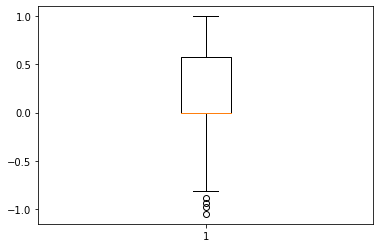

In [13]:
acc_list = []
for key in state_models.keys():
  for model_key in state_models[key].keys():
    acc_list.append(state_models[key][model_key][1])
acc_list = sorted(acc_list)
acc_list = acc_list[5:-5]
plt.boxplot(acc_list)
print(acc_list)

In [14]:
cause_counts = df.groupby(["STATE", "DECADE", "STAT_CAUSE_DESCR"])["STAT_CAUSE_DESCR"].count().reset_index(name="COUNT")
sizes_counts = df.groupby(["STATE", "DECADE", "FIRE_SIZE_CLASS"])["FIRE_SIZE_CLASS"].count().reset_index(name="COUNT")
sizes_counts = pd.merge(sizes_counts, df.groupby(["STATE", "DECADE"])["DECADE"].count().reset_index(name="TOTAL"), on=["STATE", "DECADE"])
sizes_counts

,STATE,DECADE,FIRE_SIZE_CLASS,COUNT,TOTAL
0,Alabama,1993-1999,A,2927,22618
1,Alabama,1993-1999,B,14540,22618
2,Alabama,1993-1999,C,4861,22618
3,Alabama,1993-1999,D,235,22618
4,Alabama,1993-1999,E,48,22618
...,...,...,...,...,...
1260,Wyoming,2010-2015,C,455,4125
1261,Wyoming,2010-2015,D,117,4125
1262,Wyoming,2010-2015,E,68,4125
1263,Wyoming,2010-2015,F,54,4125


# Chart Generation

In [15]:
"""
This section create a dataframe of the values that will be
used to draw circles in the given plot.
"""

# Because of the method used to plot circles, this must be a fixed value.
chart_size = 600

def get_circle_positions_by_decade(raw_data, decade):
  decade_data = raw_data[raw_data["DECADE"] == decade].groupby(["ABBV"])[("ABBV", "LAT", "LON", "STATE_DECADE_FREQUENCY")].mean()
  decade_data = decade_data.reset_index()
  return pack_circles(decade_data, "LON", "LAT", "STATE_DECADE_FREQUENCY", "ABBV")


decades = list(working_data["DECADE"].unique())
circle_positions = None
for decade in decades:
  d = get_circle_positions_by_decade(working_data, decade)
  d["DECADE"] = decade
  d["MAX_PIXEL_AREA"] = (d['CIRCLE_R'].max() * chart_size) ** 2
  if circle_positions is None:
    circle_positions = d
  else:
    circle_positions = circle_positions.append(d, ignore_index=True)

working_data = pd.merge(working_data, circle_positions, on=["ABBV", "DECADE"])


<ipython-input-15-7dce206070c0>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  decade_data = raw_data[raw_data["DECADE"] == decade].groupby(["ABBV"])[("ABBV", "LAT", "LON", "STATE_DECADE_FREQUENCY")].mean()


In [16]:
# Statistical data generation for the box plot

def quartile(n):
    def quartile_(x):
        return np.percentile(x, n * 25)
    quartile_.__name__ = 'q%s' % n
    return quartile_

stats = df.groupby(["STATE", "DECADE"]).agg({"FIRE_SIZE": [np.min, np.max, np.mean, quartile(1), quartile(3)]}).reset_index()
stats.columns = [col[0] if len(col[-1]) == 0 else col[-1] for col in stats.columns.values]
stats

,STATE,DECADE,amin,amax,mean,q1,q3
0,Alabama,1993-1999,0.1000,3321.0,10.389884,1.0,8.00
1,Alabama,2000-2004,0.0100,2784.0,13.449837,1.0,10.00
2,Alabama,2005-2009,0.0100,4394.0,16.611940,1.0,15.00
3,Alabama,2010-2015,0.0100,2950.0,17.417812,0.5,15.00
4,Alaska,1993-1999,0.1000,606945.0,1033.508860,0.1,2.00
...,...,...,...,...,...,...,...
202,Wisconsin,2010-2015,0.0050,7499.4,3.629311,0.1,0.75
203,Wyoming,1993-1999,0.1000,53930.0,101.935849,0.1,5.00
204,Wyoming,2000-2004,0.1000,137069.0,223.573567,0.1,2.00
205,Wyoming,2005-2009,0.0100,68148.0,175.056004,0.1,2.00


In [17]:
# Color functions. Used for shorthand where needed

def hex_to_rgb(hex):
  return tuple(int(hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
  return '#%02x%02x%02x' % rgb

def interpolate_hex_codes(start, end, t):
  return rgb_to_hex(interpolate_rgb(hex_to_rgb(start), hex_to_rgb(end), t))

def interpolate_rgb(rgb1, rgb2, t):
  return tuple([interpolate_int(x, y, t) for x, y in zip(rgb1, rgb2)])

def interpolate_int(i1, i2, t):
  return round(i1 + ((i2 - i1) * t))
  

In [18]:
color_range = "#ffffb2", "#b10026"
mid_color = interpolate_hex_codes(color_range[0], color_range[1], 0.5)

"""
Definition for Altair Representation of Area Schematized Cartogram
"""

decade_radio = alt.binding_radio(options=decades)
decade_select = alt.selection_single(fields=['DECADE'], bind=decade_radio, name="Decade Select", init={'DECADE': decades[0]})

state_selector = alt.selection_multi(fields=['STATE'])

""" CREATE AREA CARTOGRAM """

base = alt.Chart(working_data).encode(
  x = alt.X('CIRCLE_X', scale = alt.Scale(domain=[-1, 1]), axis=None),
  y = alt.Y('CIRCLE_Y', scale = alt.Scale(domain=[-1, 1]), axis=None),
).transform_filter(
    decade_select
)

tooltips = [
            alt.Tooltip('STATE', title="State"),
            alt.Tooltip('ABBV', title="Code"),
            alt.Tooltip('STATE_DECADE_FREQUENCY', title="Frequency"),
            alt.Tooltip('CATAGORY_LETTER', title="Weighted Fire Class"),
            ]

chart = base.mark_circle(stroke='black', strokeWidth=2).encode(
  color = alt.condition(state_selector, 'CATAGORY:Q', alt.value('lightgray'), legend=None, scale=alt.Scale(range=color_range)),
  size= alt.Size('CIRCLE_A', scale=alt.Scale(domain=[0, 4], range=[0, chart_size * chart_size]), legend=None),
  tooltip=tooltips
).properties(width=chart_size, height=chart_size)

text = base.mark_text().encode(
    text='ABBV',
    tooltip=tooltips
)
labeled_chart = ((chart + text)).add_selection(
      state_selector
).add_selection(
    decade_select
)

legend = alt.Chart(working_data).mark_circle(size=150).encode(
      x=alt.X(
          "CATAGORY_LETTER:N",
          axis=alt.Axis(domain=False, ticks=False, labelAngle=0, orient='top'),
          title="Weighted average fire size classification"
      ),

      color=alt.Color('CATAGORY:Q', legend=None, scale=alt.Scale(range=("#ffff00", "#ff0000")))
)

"""
Bar charts
"""

wav_bars = alt.Chart(working_data).mark_bar().encode(
    x=alt.X("count(CATAGORY_LETTER)", axis=alt.Axis(title='Overall Occurences')),
    y=alt.Y("CATAGORY_LETTER:N", axis=alt.Axis(title='Classification')),
    color=alt.Color('CATAGORY_LETTER', scale=alt.Scale(range=[mid_color, mid_color]), legend=None),
    tooltip=[alt.Tooltip('CATAGORY_LETTER', title="Class"), alt.Tooltip('count(CATAGORY_LETTER)', title="#")]
).transform_filter(
    decade_select
)

causes_count = len(cause_counts["STAT_CAUSE_DESCR"].unique())
causes_selection = alt.selection_multi(fields=['STAT_CAUSE_DESCR'])

causes_bars = alt.Chart(cause_counts).mark_bar().encode(
    x='STATE',
    y=alt.Y('COUNT'),
    color=alt.Color('STAT_CAUSE_DESCR', legend=None),
    tooltip=[alt.Tooltip('STATE', title="State"), alt.Tooltip('COUNT', title="#"), alt.Tooltip('STAT_CAUSE_DESCR', title="Cause")]
).transform_filter(
    decade_select
).transform_filter(
    state_selector
).transform_filter(
    causes_selection
).add_selection(
    state_selector
).add_selection(
    causes_selection
)

causes_legend = alt.Chart(cause_counts).mark_circle().encode(
    y=alt.Y('STAT_CAUSE_DESCR:N', axis=alt.Axis(orient='right')),
    color=alt.condition(causes_selection, alt.Color('STAT_CAUSE_DESCR:N', legend=None), alt.value('lightgray'))
).add_selection(
    causes_selection
)
causes_bars = causes_bars | causes_legend


fire_classifications_count = len(sizes_counts["FIRE_SIZE_CLASS"].unique())
sizes_bars = alt.Chart(sizes_counts).mark_bar().encode(
    x='STATE',
    y='COUNT',
    color=alt.Color('FIRE_SIZE_CLASS:O', scale=alt.Scale(range=[interpolate_hex_codes(color_range[0], color_range[1], i/(fire_classifications_count-1)) for i in range(fire_classifications_count)], type="ordinal")),
    tooltip=[alt.Tooltip('STATE', title="State"), alt.Tooltip('TOTAL', title="Total"),  alt.Tooltip('COUNT', title="#"), alt.Tooltip('FIRE_SIZE_CLASS', title="Class")]
).transform_filter(
    decade_select
).transform_filter(
    state_selector
).add_selection(
    state_selector
)

# Outlines are used here to aid readability
outlines = alt.Chart(sizes_counts).mark_bar(filled=False, color='black', strokeWidth=0.5).encode(
    x='STATE',
    y='TOTAL',
    #tooltip=[alt.Tooltip('STATE', title="State"), alt.Tooltip('TOTAL', title="Total"),  alt.Tooltip('COUNT', title="#"), alt.Tooltip('FIRE_SIZE_CLASS', title="Class")]
).transform_filter(
    decade_select
).transform_filter(
    state_selector
)

sizes_bars = outlines + sizes_bars

alt.data_transformers.disable_max_rows()
whiskers = alt.LayerChart(stats).encode(
    x='STATE',
    tooltip=['amin:Q', 'q1:Q', 'mean:Q', 'q3:Q', 'amax:Q']
).add_layers(
    alt.Chart().mark_rule().encode(y=alt.Y('amin:Q', scale=alt.Scale(type='log')), y2='amax:Q'),
    alt.Chart().mark_bar(width=15).encode(y='q1:Q', y2='q3:Q'),
    alt.Chart().mark_tick(color='white', width=15).encode(y='mean:Q'),
).transform_filter(
    decade_select
).transform_filter(
    state_selector
)

final_tool = ((labeled_chart | (legend & wav_bars & whiskers)) & alt.hconcat(causes_bars, sizes_bars, resolve = alt.Resolve(scale=alt.LegendResolveMap(color=alt.ResolveMode('independent')))))
final_tool

alt.VConcatChart(...)